In [1]:
import numpy as np
from matplotlib import pyplot as plt 
import pdb

In [2]:
def F_1(X):
    #pdb.set_trace()
    if len(X.shape) == 1:
        X_0s = X[0]
    else:
        X_0s = X[:,0]
    return np.minimum(X_0s, 20-X_0s)

In [3]:
def Booth(X):
    if len(X.shape) == 1:
        return -(X[0]+2*X[1]-7)**2 + (2*X[0]+X[1]-5)**2
    else:
        return -(X[:,0]+2*X[:,1]-7)**2 + (2*X[:,0]+X[:,1]-5)**2

In [4]:
def CEM(num_iters, F, pop_size=10):
    cov_norms = np.zeros(num_iters)
    N = pop_size # population
    d = 2 # dimension of problem
    p = 0.5 # elite fraction
    elite_k = int(p*N)

    mu = np.random.randn(d) # std normal init
    cov = 0.1*np.eye(d) # initialize sigma to 0.1? Can change this

    for i in range(num_iters):
        if i % 50 == 0:
            print("iteration: ", str(i))
            print("cov norm: ", np.linalg.norm(cov))
            print("F val: ", F(mu))
    
    
        # sample noise
        x_guesses = np.random.multivariate_normal(mean=mu, cov=cov, size=N)
        #print("x guesses shape: ", x_guesses.shape)
    
        # eval sample
        Fs = F(x_guesses)
        #print("Fs shape: ", Fs.shape)
        
        # compute elite set
        elite_idx = (-Fs).argsort()[:elite_k]
        #print("elite idx: ", elite_idx)

        Fs_elite = Fs[elite_idx]
        #print(Fs_elite)
        Fs_elite_xs = x_guesses[elite_idx]
        
        mu = np.mean(Fs_elite_xs, axis=0)
        #print("mu shape: ", mu.shape)
        
        # fit covariance
        # Xs_elite - mu
        
        res1 = Fs_elite_xs - mu
        #res1 = np.sum(res1)
        #print("res1 shape: ", res1.shape)
        res = np.dot(res1.T,res1)
        #print("res cov shape: ", res.shape)
        cov = (1/elite_k)*np.dot(res1.T,res1)
        # extract diag
        cov = np.diag(cov)
        # create matrix
        cov = np.diag(cov)
        cov_norms[i] = np.linalg.norm(cov)
        #print("COV: ", cov)
        
    return mu, cov_norms

In [5]:
num_iters = 100
mu, cov_norms = CEM(num_iters, F_1)

iteration:  0
cov norm:  0.14142135623730953
F val:  0.9073057168191517
iteration:  50
cov norm:  1.5995730257517393e-17
F val:  1.8512844913739392


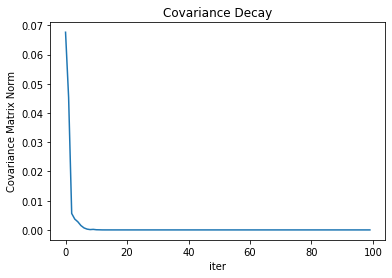

In [6]:
# plot cov norm
x = np.arange(num_iters) 
y = cov_norms
plt.title("Covariance Decay") 
plt.xlabel("iter") 
plt.ylabel("Covariance Matrix Norm") 
plt.plot(x,y) 
plt.show()

We've just shown that normal CEM suffers from covariance decay. Now let's try to implement Noisy CEM

In [7]:
def noisy_CEM(num_iters, F, pop_size=10):
    cov_norms = np.zeros(num_iters)
    N = pop_size # population
    d = 2 # dimension of problem
    p = 0.5 # elite fraction
    elite_k = int(p*N)
    obj_vals = np.zeros(num_iters)

    mu = np.random.randn(d) # std normal init
    cov = 0.1*np.eye(d) # initialize sigma to 0.1? Can change this
    print("init cov shape: ", cov.shape)

    for i in range(num_iters):
        if i % 50 == 0:
            print("iteration: ", str(i))
            print("cov shape: ", cov.shape)
            print("cov norm: ", np.linalg.norm(cov))
            print("F val: ", F(mu))
    
    
        # sample noise
        x_guesses = np.random.multivariate_normal(mean=mu, cov=cov, size=N)
        #print("x guesses shape: ", x_guesses.shape)
    
        # eval sample
        Fs = F(x_guesses)
        #print("Fs shape: ", Fs.shape)
        
        # compute elite set
        elite_idx = (-Fs).argsort()[:elite_k]
        #print("elite idx: ", elite_idx)

        Fs_elite = Fs[elite_idx]
        #print(Fs_elite)
        Fs_elite_xs = x_guesses[elite_idx]
        
        mu = np.mean(Fs_elite_xs, axis=0)
        #print("mu shape: ", mu.shape)
        
        # fit covariance
        # Xs_elite - mu
        
        res1 = Fs_elite_xs - mu
        #res1 = np.sum(res1)
        #print("res1 shape: ", res1.shape)
        avg_elite = np.mean(res1,axis=0)
        s_i = 1 - i/float(num_iters)
        sigma_squared = avg_elite**2 + s_i**2
        #print("sigma square shape: ", sigma_squared.shape)
        cov = np.diag(cov)
        cov = np.diag(cov)
        #print("cov shape: ", cov.shape)
        cov_norms[i] = np.linalg.norm(cov)
        obj_vals[i] = F(mu)
        
    return mu, cov_norms, obj_vals

In [8]:
num_iters = 100
mu, cov_norms, obj_vals = noisy_CEM(num_iters, F_1)

init cov shape:  (2, 2)
iteration:  0
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  -1.5398593141543129
iteration:  50
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  9.964186014658416


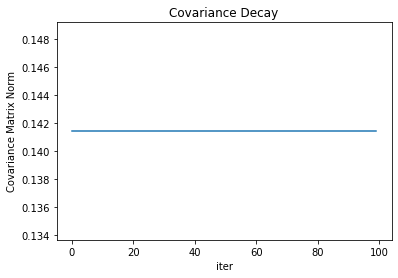

In [9]:
# plot cov norm
x = np.arange(num_iters) 
y = cov_norms
plt.title("Covariance Decay") 
plt.xlabel("iter") 
plt.ylabel("Covariance Matrix Norm") 
plt.plot(x,y) 
plt.show()

In [10]:
print(mu)

[9.95496459 0.0941619 ]


Our new alg, noisy CEM, finds the max solution, $x_0 = 10$

In [11]:
num_iters = 100
mu, cov_norms, obj_vals = noisy_CEM(num_iters, Booth)

init cov shape:  (2, 2)
iteration:  0
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  -6.538705825925032
iteration:  50
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  521.2909405338993


In [12]:
print(mu)

[-22.68137643   2.98933836]


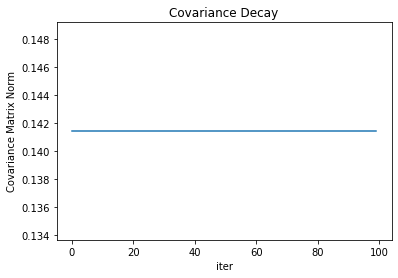

In [13]:
# plot cov norm
x = np.arange(num_iters) 
y = cov_norms
plt.title("Covariance Decay") 
plt.xlabel("iter") 
plt.ylabel("Covariance Matrix Norm") 
plt.plot(x,y) 
plt.show()

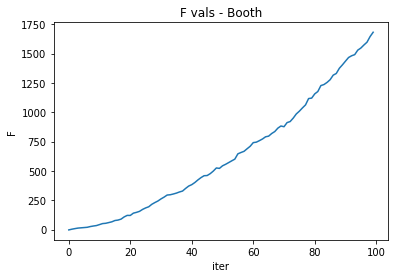

In [14]:
# plot obj vals
x = np.arange(num_iters) 
y = obj_vals
plt.title("F vals - Booth") 
plt.xlabel("iter") 
plt.ylabel("F") 
plt.plot(x,y) 
plt.show()

In [15]:
# Test on quadratic function


def Quadratic(X): # X is N by d
    A = [[2.,6],[6,20]]
    A = np.asarray(A)
    B = [2,4]
    B = np.asarray(B)
    B = np.expand_dims(B,axis=1)
    results = np.zeros(X.shape[0])
    if len(X.shape) == 1:
        return -X.T @ A @ X + np.dot(B.T,X)
    for i in range(X.shape[0]):
        results[i] = X[i,:].T @ A @ X[i,:] + np.dot(B.T,X[i,:])
    return -1* results

In [16]:
def Quadratic2(X): # X is N by d
    A = [[2.,6],[6,20]]
    A = np.asarray(A)
    B = [2,4]
    B = np.asarray(B)
    B = np.expand_dims(B,axis=1)
    results = np.zeros(X.shape[0])
    if len(X.shape) == 1:
        return -X.T @ A @ X 
    for i in range(X.shape[0]):
        results[i] = X[i,:].T @ A @ X[i,:] 
    return -1* results

In [17]:
X = np.random.randn(10,2)
res = Quadratic(X)
print(res.shape)

(10,)


In [18]:
num_iters = 100
mu, cov_norms, obj_vals = noisy_CEM(num_iters, Quadratic)

init cov shape:  (2, 2)
iteration:  0
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  [-0.25617627]
iteration:  50
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  [-0.50567778]


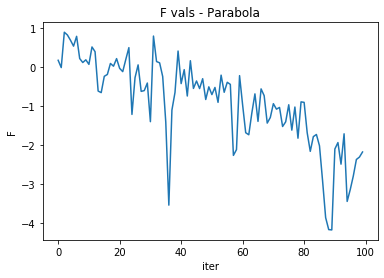

In [19]:
# plot obj vals
x = np.arange(num_iters) 
y = obj_vals
plt.title("F vals - Parabola") 
plt.xlabel("iter") 
plt.ylabel("F") 
plt.plot(x,y) 
plt.show()

In [20]:
num_iters = 1000
mu, cov_norms, obj_vals = noisy_CEM(num_iters, Quadratic, pop_size=50)

init cov shape:  (2, 2)
iteration:  0
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  [-29.99375388]
iteration:  50
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  [-1.56137162]
iteration:  100
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  [-2.87423288]
iteration:  150
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  [-2.68512584]
iteration:  200
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  [-2.07034292]
iteration:  250
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  [-2.82792094]
iteration:  300
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  [-3.21237346]
iteration:  350
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  [-2.83101254]
iteration:  400
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  [-3.71312214]
iteration:  450
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  [-4.06292664]
iteration:  500
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  [-2.4972913]
iteration: 

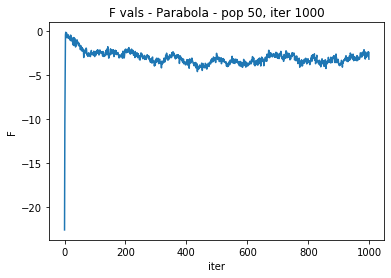

In [21]:
# plot obj vals
x = np.arange(num_iters) 
y = obj_vals
plt.title("F vals - Parabola - pop 50, iter 1000") 
plt.xlabel("iter") 
plt.ylabel("F") 
plt.plot(x,y) 
plt.show()

In [22]:
X = np.random.randn(10,2)
res = Quadratic(X)
print(res.shape)

(10,)


Alg is not converging at maximum value, 0

#### Rosenbrock

In [23]:
def Rosenbrock(X):
    if len(X.shape) == 1:
        val = -1*(1-X[0])**2 + 100*(X[1]-X[0]**2)**2
        return val
    else:
        vals = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            vals[i] = (1-X[i,0])**2 + 100*(X[i,1]-X[i,0]**2)**2
        return -1*vals

In [24]:
num_iters = 1000
mu, cov_norms, obj_vals = noisy_CEM(num_iters, Rosenbrock, pop_size=50)

init cov shape:  (2, 2)
iteration:  0
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  165.8835440393455
iteration:  50
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  -0.4587002167996693
iteration:  100
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  0.15136215237214012
iteration:  150
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  -0.4835181982348479
iteration:  200
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  0.02544910596223038
iteration:  250
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  0.3559961783265848
iteration:  300
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  0.2538231094129235
iteration:  350
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  0.5111111234676646
iteration:  400
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  -0.1964313856142783
iteration:  450
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  -0.23789990493855484
iteration:  500
cov shape:  (2, 2)
cov norm

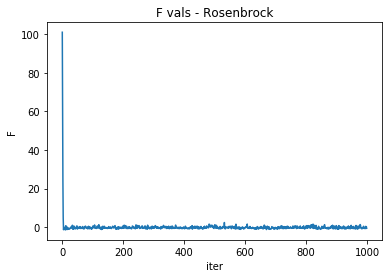

In [25]:
# plot obj vals
x = np.arange(num_iters) 
y = obj_vals
plt.title("F vals - Rosenbrock") 
plt.xlabel("iter") 
plt.ylabel("F") 
plt.plot(x,y) 
plt.show()

In [26]:
print(mu)

[0.10111488 0.05880098]


It looks like we are converging to the Rosenbrock valley, but not the global minimum.

from [mathworks](https://www.mathworks.com/matlabcentral/mlc-downloads/downloads/submissions/23972/versions/22/previews/chebfun/examples/opt/html/Rosenbrock.html)

$f(x,y) = (1-x)^2 + 100 \cdot (y-x^2)^2$

has global min of $0$ at $(x,y) = (1,1)$

#### How can we fix this?

Perhaps there's not enough exploration.... increase noise for covariance?

What happens if we set $s_t = 1$, i.e. make sure cov is at least 1?

In [27]:
def fix_noisy_CEM(num_iters, F, pop_size=10, ):
    cov_norms = np.zeros(num_iters)
    N = pop_size # population
    d = 2 # dimension of problem
    p = 0.5 # elite fraction
    elite_k = int(p*N)
    obj_vals = np.zeros(num_iters)

    mu = np.random.randn(d) # std normal init
    cov = 0.1*np.eye(d) # initialize sigma to 0.1? Can change this
    print("init cov shape: ", cov.shape)

    for i in range(num_iters):
        if i % 50 == 0:
            print("iteration: ", str(i))
            print("cov shape: ", cov.shape)
            print("cov norm: ", np.linalg.norm(cov))
            print("F val: ", F(mu))
    
    
        # sample noise
        x_guesses = np.random.multivariate_normal(mean=mu, cov=cov, size=N)
        #print("x guesses shape: ", x_guesses.shape)
    
        # eval sample
        Fs = F(x_guesses)
        #print("Fs shape: ", Fs.shape)
        
        # compute elite set
        elite_idx = (-Fs).argsort()[:elite_k]
        #print("elite idx: ", elite_idx)

        Fs_elite = Fs[elite_idx]
        #print(Fs_elite)
        Fs_elite_xs = x_guesses[elite_idx]
        
        mu = np.mean(Fs_elite_xs, axis=0)
        #print("mu shape: ", mu.shape)
        
        # fit covariance
        # Xs_elite - mu
        
        res1 = Fs_elite_xs - mu
        #res1 = np.sum(res1)
        #print("res1 shape: ", res1.shape)
        avg_elite = np.mean(res1,axis=0)
        s_i = 1 - i/(2*num_iters)
        sigma_squared = avg_elite**2 + s_i**2
        #print("sigma square shape: ", sigma_squared.shape)
        cov = np.diag(cov)
        cov = np.diag(cov)
        #print("cov shape: ", cov.shape)
        cov_norms[i] = np.linalg.norm(cov)
        obj_vals[i] = F(mu)
        
    return mu, cov_norms, obj_vals

In [28]:
num_iters = 1000
mu, cov_norms, obj_vals = fix_noisy_CEM(num_iters, Rosenbrock, pop_size=50)

init cov shape:  (2, 2)
iteration:  0
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  22.223343741930897
iteration:  50
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  -0.27287255013587886
iteration:  100
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  0.36093724327476495
iteration:  150
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  -0.39100898196517875
iteration:  200
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  1.62153658718838
iteration:  250
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  -0.8845932366999837
iteration:  300
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  -0.38862571330071816
iteration:  350
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  1.2395206046825873
iteration:  400
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  0.09027785984395087
iteration:  450
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  0.33113371217245535
iteration:  500
cov shape:  (2, 2)
cov no

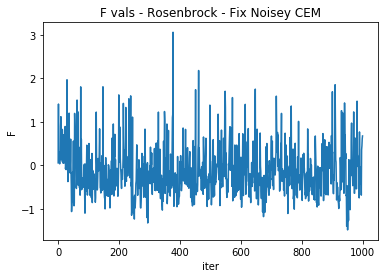

In [29]:
# plot obj vals
x = np.arange(num_iters) 
y = obj_vals
plt.title("F vals - Rosenbrock - Fix Noisey CEM") 
plt.xlabel("iter") 
plt.ylabel("F") 
plt.plot(x,y) 
plt.show()

In [30]:
print(mu)

[0.16084407 0.14339513]


#### It looks like we are already in the saddle, when we initialize mu around the standard normal

So... can see what happens if we initialize mu further out

#### Ok, let's try to make rosenbrock noisy

In [31]:
def NoisyRosenbrock(X):
    if len(X.shape) == 1:
        val = -1*(1-X[0])**2 + 100*(X[1]-X[0]**2)**2 + np.random.randn()
        return val
    else:
        vals = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            vals[i] = (1-X[i,0])**2 + 100*(X[i,1]-X[i,0]**2)**2 + np.random.randn()
        return -1*vals

In [32]:
num_iters = 1000
mu, cov_norms, obj_vals = noisy_CEM(num_iters, NoisyRosenbrock, pop_size=50)

init cov shape:  (2, 2)
iteration:  0
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  243.05913082815425
iteration:  50
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  -1.3440480721335075
iteration:  100
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  0.49562456722657
iteration:  150
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  -1.0523336193966333
iteration:  200
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  0.1684051456169865
iteration:  250
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  -0.36712752914088465
iteration:  300
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  -0.6000530160465598
iteration:  350
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  0.6928331397567101
iteration:  400
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  -1.452742576159228
iteration:  450
cov shape:  (2, 2)
cov norm:  0.14142135623730953
F val:  -0.3867042519858734
iteration:  500
cov shape:  (2, 2)
cov norm: 

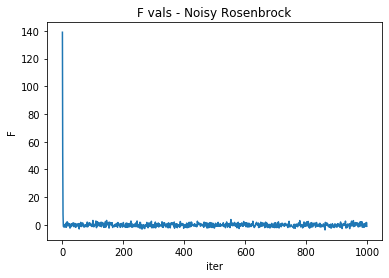

In [33]:
x = np.arange(num_iters) 
y = obj_vals
plt.title("F vals - Noisy Rosenbrock") 
plt.xlabel("iter") 
plt.ylabel("F") 
plt.plot(x,y) 
plt.show()

In [34]:
# plot the F values

In [35]:
# x = np.linspace(-10, 10, 150)
# y = np.linspace(-10, 10, 150)

# X, Y = np.meshgrid(x, y)
# print(X.shape)
# print(Y.shape)
# Xs = np.zeros(150*150,2)
# for i i 

# Z = Booth(X)
# print(Z.shape)

In [36]:
# # Test on quadratic fn
# d = 2
# M = np.random.rand(d, d)
# # make it positive semidefinite
# A = np.dot(M, M.T)
# print(A)
# B = np.random.rand(d)
# print(B)
# C = np.random.rand()